<a href="https://colab.research.google.com/github/rdiazrincon/SLEAP_Data/blob/master/analysis/prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for behavioral prediction of differences in dominant vs subordinate mice during reward competition 

### (Optional) Installing required packages

**Note:** If you are runnning this Notebook from Colab most packages will be already installed. But please do so if you are running locally.

In [1]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install tables

### Importing packages

In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d

### Getting the data from Github 

**Note:** Run this if you are using Colab. It will save the labeled data in your current directory.

In [3]:
# !wget -O prediction_analysis.h5 https://github.com/rdiazrincon/SLEAP_Data/blob/master/analysis/data/prediction_analysis.h5

### Setting up the paths for labeled data and reward competition info

In [4]:
path = "data/prediction_analysis.h5"
intervals = "data/WL_info_by_timestamp.csv"

## Exploring the data

In [5]:
# Opening the H5 file
with h5py.File(path, "r") as f:
    dataset_keys = list(f.keys())
    tracks = f["tracks"][:].T
    bodyparts = [n.decode() for n in f["node_names"][:]]

print(f"Filename:{path}")
print(f"Array keys{dataset_keys}:")
print(f"Behavioral data shape:{tracks.shape}")
print(f"Body parts{bodyparts}")

Filename:data/prediction_analysis.h5
Array keys['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']:
Behavioral data shape:(54546, 6, 2, 2)
Body parts['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']


## Understanding the data 

We only work with the tracks array. It contains information regarding Number of Frames, Number of Bodyparts, Number of Coordinates and Number of instances.


In [6]:
# Here's what each dimension of the matrix's shape means
n_frames, n_bodyparts, n_coordinates, n_instances = tracks.shape

print(f"Number of Frames: {n_frames}")
print(f"Number of Bodyparts: {n_bodyparts}")
print(f"Number of Coordinates: {n_coordinates}")
print(f"NUmber of Instances: {n_instances}")

Number of Frames: 54546
Number of Bodyparts: 6
Number of Coordinates: 2
NUmber of Instances: 2


### Exploring (and making sense out of) the data

- The tracks array contains all of the information we need. 
- The first dimension of the array will provide us with information regarding the frames labeled in the video. 
- The second dimension relates to each body part (6 in our case). Note that, in the example below, we get data from the forehead by accesing position 5 in the array. 
- The third dimension relates to the X and Y coordinates and the fourth dimension to the number if animals/mice/instances


#### First frame 

In [7]:
print(tracks[0])

[[[184.44789124 315.60144043]
  [351.55776978 379.87524414]]

 [[140.21481323 284.03588867]
  [364.47213745 367.95025635]]

 [[183.75314331 319.75219727]
  [404.18869019 427.59402466]]

 [[147.53791809 412.41549683]
  [208.04371643 216.35691833]]

 [[148.6204834  339.65484619]
  [324.4312439  299.75323486]]

 [[168.43464661 296.26281738]
  [367.9828186  387.65563965]]]


#### Forehead coordinates for both mouse in Frame 1

**Note:** You can find the forehead data in position 5 of the tracks array. In general, the "bodyparts" array contains information regarding the position of bodyparts.
 

In [8]:
print(tracks[0][5])

[[168.43464661 296.26281738]
 [367.9828186  387.65563965]]


#### Forehead X-coordinate for both mouse in Frame 1

In [9]:
print(tracks[0][5][0])

[168.43464661 296.26281738]


#### Forehead Y-coordinate for mouse 2 in Frame 1.

In [10]:
print(tracks[0][5][0][1]) 

296.2628173828125


## Now let's mess around with the data ...

### Fill-in missing values

We won't drop the NaN values but will fill them with Non Zero values so the analysis is easier to make

In [11]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

After filling out the NaN values with None Zero values, the array maintains the same shape

In [12]:
tracks = fill_missing(tracks)
print(tracks.shape)

(54546, 6, 2, 2)


### Reading and handling information related to Reward Competition

The information in the Frames column relates to the frames that make up a Trial. We will be reading a file to get this information


In [13]:
df_trials = pd.read_csv(intervals)['Frame']
df_trials

0       2100-2400
1       4470-4770
2       7140-7440
3       9510-9810
4     11730-12030
5     14670-14970
6     17520-17820
7     20160-20460
8     22530-22830
9     25200-25500
10    28140-28440
11    30840-31140
12    34410-34710
13    37050-37350
14    39570-39870
15    42210-42510
16    45030-45330
17    48600-48900
18    50970-51270
19    53790-54090
Name: Frame, dtype: object

### Converting the trials DataFrame to an array

Using the dash to separate each trial in an array

In [14]:
trials_array_separated = [trial.split("-") for trial in df_trials] # Returns a list of lists
print(trials_array_separated)

[['2100', '2400'], ['4470', '4770'], ['7140', '7440'], ['9510', '9810'], ['11730', '12030'], ['14670', '14970'], ['17520', '17820'], ['20160', '20460'], ['22530', '22830'], ['25200', '25500'], ['28140', '28440'], ['30840', '31140'], ['34410', '34710'], ['37050', '37350'], ['39570', '39870'], ['42210', '42510'], ['45030', '45330'], ['48600', '48900'], ['50970', '51270'], ['53790', '54090']]


Looping through the nested array, converting each (str) element to int and appending the elements in a new array 


In [15]:
trials_array = [int(j) for i in range(len(trials_array_separated)) for j in trials_array_separated[i]]
print(trials_array)

# Leaving this here for future reference
# for i in range(len(trials_array_separated)):
#     for j in trials_array_separated[i]:
#         trials_array.append(eval(j))
        
# trials_array

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


## Getting information on mice coordinates based in trials 

For each body part, we loop through the set of frames that comprise a single trial. We repeat for all the trials in the competition (20).
Each video has 30 frames per second(FPS) and each trial lasts 10 second.

In [16]:
LEFT_EAR_INDEX = 0
RIGHT_EAR_INDEX = 1
NOSE_INDEX = 2
TAIL_BASE_INDEX = 3
THORAX_INDEX = 4
FOREHEAD_INDEX = 5

TRIAL_LENGTH_SECONDS = 10
N_TRIALS = 20
FPS = 30

time_window_seconds = 15

frames_per_trial = FPS * TRIAL_LENGTH_SECONDS
time_window_frames = FPS * time_window_seconds

left_ear_loc_aux = []
right_ear_loc_aux = []
nose_loc_aux = []
tail_base_loc_aux = []
thorax_loc_aux = []
forehead_loc_aux = []

Using the onset information to target a different set of frames. Now we are looking at the frames that occur 30 seconds prior to the tone onset and 30 seconds before the tone onset. That is, we will be looking at time_window_frames frames before and after

In [17]:
it = iter(trials_array)
trials_array_onset = []
for i, j in zip(it, it):
    trials_array_onset.append(i - time_window_frames)
    trials_array_onset.append(j)

In [18]:
print(trials_array_onset)     

[1650, 2400, 4020, 4770, 6690, 7440, 9060, 9810, 11280, 12030, 14220, 14970, 17070, 17820, 19710, 20460, 22080, 22830, 24750, 25500, 27690, 28440, 30390, 31140, 33960, 34710, 36600, 37350, 39120, 39870, 41760, 42510, 44580, 45330, 48150, 48900, 50520, 51270, 53340, 54090]


In [19]:
print(trials_array)     

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


Using the trials_array to loop through the intervals (first_frame_in_trial:last_frame_in_trial) and fill the vector with the coordinates corresponding for both mice and their body parts  


In [20]:
iterator = iter(trials_array_onset)
for first_frame_in_trial, last_frame_in_trial in zip(iterator, iterator):
    # print(len(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :]))
    left_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, LEFT_EAR_INDEX, :, :])
    right_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :])
    nose_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, NOSE_INDEX, :, :])
    tail_base_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, TAIL_BASE_INDEX, :, :])
    thorax_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, THORAX_INDEX, :, :])
    forehead_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, FOREHEAD_INDEX, :, :])

frames_in_trial = last_frame_in_trial - first_frame_in_trial

In [21]:
array_shape = np.asarray(left_ear_loc_aux).shape
print(f"Old shape: {array_shape}")
left_ear_loc = np.asarray(left_ear_loc_aux).reshape(N_TRIALS * frames_in_trial , n_coordinates, n_instances)
print(f"New shape: {left_ear_loc.shape}")
right_ear_loc = np.asarray(right_ear_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
nose_loc = np.asarray(nose_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
tail_base_loc = np.asarray(tail_base_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
thorax_loc = np.asarray(thorax_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
forehead_loc = np.asarray(forehead_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)

Old shape: (20, 750, 2, 2)
New shape: (15000, 2, 2)


### Converting our data into a Tabular format

In [22]:
# There is definitely an easier way of doing this but I don't have the time now

bp = ['left_ear', 'right_ear', 'thorax', 'tail', 'nose']
coord = ['x', 'y']
for i in range(1):
    for j in range(1):
        df_bla = {
            'm{j}_{bp[{0}]}_{i}': left_ear_loc[:, i, j]
        }

df = pd.DataFrame({
    'm1_left_ear_x': left_ear_loc[:, 0, 0], 
    'm1_left_ear_y': left_ear_loc[:, 1, 0], 
    "m2_left_ear_x": left_ear_loc[:, 0, 1],
    "m2_left_ear_y": left_ear_loc[:, 1, 1],

    'm1_right_ear_x': right_ear_loc[:, 0, 0], 
    'm1_right_ear_y': right_ear_loc[:, 1, 0], 
    "m2_right_ear_x": right_ear_loc[:, 0, 1],
    "m2_right_ear_y": right_ear_loc[:, 1, 1],
    
    'm1_nose_x': nose_loc[:, 0, 0], 
    'm1_nose_y': nose_loc[:, 1, 0], 
    "m2_nose_x": nose_loc[:, 0, 1],
    "m2_nose_y": nose_loc[:, 1, 1],

    'm1_tail_base_x': tail_base_loc[:, 0, 0], 
    'm1_tail_base_y': tail_base_loc[:, 1, 0], 
    "m2_tail_base_x": tail_base_loc[:, 0, 1],
    "m2_tail_base_y": tail_base_loc[:, 1, 1],

    'm1_thorax_x': thorax_loc[:, 0, 0], 
    'm1_thorax_y': thorax_loc[:, 1, 0], 
    "m2_thorax_x": thorax_loc[:, 0, 1],
    "m2_thorax_y": thorax_loc[:, 1, 1],

    'm1_forehead_x': forehead_loc[:, 0, 0], 
    'm1_forehead_y': forehead_loc[:, 1, 0], 
    "m2_forehead_x": forehead_loc[:, 0, 1],
    "m2_forehead_y": forehead_loc[:, 1, 1],
    })
df

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
0,347.890289,316.498230,552.264404,236.391174,303.732544,343.525574,512.929914,280.614905,332.042297,387.682739,...,489.675885,325.718874,272.194611,296.181000,578.550226,298.541272,331.732635,347.699707,572.148193,235.906601
1,347.838531,316.558167,560.189297,241.687761,300.654053,343.988464,469.516636,300.575396,332.041870,387.976654,...,496.141809,314.488010,272.336395,299.664307,577.416675,300.914850,331.703674,348.014648,560.254028,231.729752
2,347.910065,316.548615,568.114190,246.984348,303.796875,344.706390,426.103359,320.535886,335.681305,384.080444,...,502.607733,303.257146,272.314392,300.173889,576.283124,303.288428,331.934631,348.211060,555.931000,230.217468
3,351.628845,315.460510,576.039083,252.280935,304.556152,339.674500,382.690081,340.496377,328.006104,383.579926,...,509.073657,292.026282,271.777252,296.035187,575.149573,305.662006,332.334259,339.915161,551.607971,228.705185
4,352.077881,311.908752,583.963976,257.577521,308.612488,336.490234,339.276803,360.456868,332.023132,352.524628,...,515.539581,280.795418,271.527802,292.011658,574.016022,308.035583,335.935577,332.356750,548.077393,231.806580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,324.019257,380.543854,236.562531,372.530457,280.293396,380.155640,196.307007,388.662689,311.529327,424.361389,...,147.436615,247.510895,276.144226,316.085999,188.056274,323.609253,304.295227,396.221283,220.535690,392.273529
14996,324.042328,380.474396,239.551392,372.427856,280.374542,380.007629,196.401520,388.597717,311.558105,424.339417,...,147.521362,247.523239,276.180511,316.004486,188.214462,323.876678,304.328369,396.156708,223.614609,392.170624
14997,323.935272,380.598358,239.575912,372.512695,279.937714,380.215118,196.347336,391.510345,311.636200,424.192688,...,147.458389,247.574310,276.176422,315.910980,188.025620,323.849854,304.205322,396.180847,223.655334,392.270782
14998,323.913208,383.466827,239.627777,372.315765,279.882599,380.290009,196.493118,388.663361,311.634827,424.190430,...,144.364548,247.583237,276.189575,315.953705,187.900620,323.686401,304.202362,396.210602,223.748444,392.159973


### Further exploration of the data

In [23]:
df.describe()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,316.121887,336.626192,307.702633,358.033788,284.452011,342.463890,270.686924,361.816830,312.400175,369.437811,...,258.556721,237.033905,287.849183,298.835227,277.162449,312.471421,303.311992,348.142814,291.972587,369.687325
std,90.041325,78.082947,83.111933,37.668468,93.203438,80.125608,86.074886,39.884836,86.023909,89.636533,...,109.479266,37.470925,96.214038,59.117805,94.223565,32.574521,90.136691,80.026837,82.001071,37.495353
min,31.869001,8.605143,19.827496,96.480621,8.622891,27.375624,5.618383,91.699699,19.520159,8.362377,...,8.341007,112.067284,28.068144,56.133495,27.870108,136.229919,23.986988,35.813320,5.711156,99.768753
25%,279.978714,324.390335,267.868431,343.598244,252.510265,339.926735,231.748707,346.828386,283.414990,364.310310,...,172.384014,212.494598,235.574203,287.903496,223.918385,295.938622,272.169952,340.680660,256.075340,355.954987
50%,319.899368,363.456512,319.791962,367.733688,280.364670,367.958038,279.770905,371.609955,308.504547,407.580704,...,247.759544,232.226494,279.825226,316.212692,276.508224,320.096359,300.210709,380.210281,299.967072,384.032013
75%,328.137383,383.758492,324.376213,383.818428,291.784348,383.624924,285.777499,383.670280,328.045898,423.513130,...,323.343750,259.841492,320.355240,331.985222,304.691658,332.099747,315.625336,392.268761,308.520798,395.545059
max,627.274475,443.329468,628.762451,436.115326,630.346130,443.735901,627.367554,448.298676,631.520691,468.414185,...,591.489807,379.713745,612.270691,403.905762,608.155334,415.644318,629.592590,428.162903,629.023132,424.100983


In [24]:
df.sample()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
1672,327.556,375.672028,267.472839,324.298157,299.703888,340.04126,212.433289,319.48645,307.854919,376.389832,...,264.082916,188.165344,364.317505,303.544067,240.468704,268.512115,307.833893,360.013397,244.148972,335.982971


In [25]:
df.value_counts()

m1_left_ear_x  m1_left_ear_y  m2_left_ear_x  m2_left_ear_y  m1_right_ear_x  m1_right_ear_y  m2_right_ear_x  m2_right_ear_y  m1_nose_x   m1_nose_y   m2_nose_x   m2_nose_y   m1_tail_base_x  m1_tail_base_y  m2_tail_base_x  m2_tail_base_y  m1_thorax_x  m1_thorax_y  m2_thorax_x  m2_thorax_y  m1_forehead_x  m1_forehead_y  m2_forehead_x  m2_forehead_y
31.869001      96.698921      324.381256     376.488037     67.777946       64.112404       283.706299      355.538513      35.505108   75.262909   304.014252  423.699615  143.559677      184.033173      359.759125      212.440536      80.283249    112.201256   319.840637   308.028046   43.780216      87.305992      299.696960     383.755371       1
324.097900     384.092743     336.488556     215.947968     288.219788      363.670624      344.233002      171.893494      303.738922  423.985382  299.746796  203.631500  291.342834      235.658020      495.831512      279.331573      315.990448   319.670044   375.897339   196.250626   303.624390   

In [26]:
df2 = pd.read_csv(intervals)['Winner (1:M_1,0:M_2,2:Tie)']
df2

0     1
1     2
2     0
3     1
4     2
5     2
6     2
7     0
8     2
9     2
10    1
11    2
12    1
13    0
14    0
15    0
16    2
17    2
18    2
19    0
Name: Winner (1:M_1,0:M_2,2:Tie), dtype: int64

In [27]:
features_array = df2.to_numpy().repeat(frames_in_trial)
print(features_array.shape)

(15000,)


### Running Random Forest for prediction

In [28]:
X = df
Y = features_array

In [29]:
X.shape

(15000, 24)

In [30]:
Y.shape

(15000,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [32]:
model = RandomForestClassifier(n_estimators = 10, random_state = 30)

In [33]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=30)

In [34]:
df_see_frames = X_test.index
df_see_frames

Int64Index([ 2930,  5102, 13365, 10803, 10889,   140,  1756,  7271,  4607,
             9834,
            ...
             1770,  8948, 12685,  1476, 10973,  9573, 13543, 10700, 11313,
             5892],
           dtype='int64', length=3000)

In [35]:
prediction_test = model.predict(X_test)
prediction_test

array([1, 2, 2, ..., 0, 0, 0])

In [36]:
prediction_probability = model.predict_proba(X_test)
prediction_probability

array([[0. , 1. , 0. ],
       [0. , 0.2, 0.8],
       [0.1, 0.1, 0.8],
       ...,
       [0.9, 0.1, 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ]])

In [37]:
print (f"Accuracy: {metrics.accuracy_score(y_test, prediction_test):.2f}")

Accuracy: 0.97


In [38]:
print(model.score(X_test, y_test))

0.969


In [39]:
X_test

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
2930,307.523315,304.113342,323.918274,364.352417,260.268158,304.293121,283.962036,388.412964,279.981537,328.336884,...,164.245468,259.541565,279.942413,244.007217,248.248245,331.560059,283.736328,312.242798,311.744690,387.737244
5102,323.801453,359.951782,315.878754,291.991058,291.493011,395.411438,259.789337,312.183746,331.654297,416.309814,...,183.642624,231.976807,252.122437,348.517670,243.541016,259.774048,316.684875,387.656128,291.645508,308.019806
13365,320.147034,364.110992,319.968658,300.050232,279.732910,395.448883,275.967773,308.112427,328.107849,408.009979,...,223.767868,203.882706,244.332687,336.378296,276.260559,263.491150,311.799133,387.524841,304.230225,308.180878
10803,268.619293,219.794861,311.748230,324.084442,299.906403,187.177521,275.393738,356.036285,252.381027,184.357986,...,196.430786,239.618011,293.113444,210.842356,244.314819,304.327881,272.147339,199.362350,299.658325,359.536652
10889,204.067551,135.521027,324.036438,380.518341,255.615341,103.702713,280.128082,372.130615,208.203293,111.185799,...,259.590942,236.672974,259.731781,159.886169,291.970581,332.091370,228.148682,119.514275,303.686462,395.641510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,320.112885,387.788910,431.787781,367.994568,284.440765,360.507721,408.205139,323.791138,303.954712,423.831146,...,519.713379,276.237366,323.466827,323.764893,463.947510,311.888123,299.695801,384.037628,416.326721,347.731995
13543,288.067749,316.066895,331.711243,308.347076,272.300079,375.930450,283.309753,292.497650,324.650116,364.007629,...,332.286896,152.456238,216.201416,323.653442,304.455750,247.658264,292.205261,348.181030,311.526276,320.330261
10700,324.227173,395.747467,268.334320,359.950439,288.071899,368.107483,215.610397,375.913574,311.826355,419.887970,...,247.586624,212.495834,332.003876,316.327911,227.977814,311.844238,303.702667,388.450714,248.262482,379.713348
11313,324.302063,387.960846,175.691177,304.201782,287.497345,367.543060,147.921921,356.123718,303.965210,423.965485,...,95.612335,256.092010,307.909821,323.814240,128.333023,316.289215,303.470551,391.983246,175.940674,332.229553


In [40]:
confusion_matrix_table = pd.DataFrame({"Frame": df_see_frames, "Predicted Class Label": np.array(prediction_test), "Actual Class Label": np.array(y_test),})
confusion_matrix_table = confusion_matrix_table.sort_values(by='Frame', ascending=True)
confusion_matrix_table

,Frame,Predicted Class Label,Actual Class Label
1202,13,1,1
2548,25,1,1
1962,29,1,1
714,32,1,1
306,38,1,1
...,...,...,...
1436,14973,0,0
283,14976,0,0
2233,14992,0,0
2277,14994,0,0


In [41]:
feature_list = list(X.columns)
feature_list

['m1_left_ear_x',
 'm1_left_ear_y',
 'm2_left_ear_x',
 'm2_left_ear_y',
 'm1_right_ear_x',
 'm1_right_ear_y',
 'm2_right_ear_x',
 'm2_right_ear_y',
 'm1_nose_x',
 'm1_nose_y',
 'm2_nose_x',
 'm2_nose_y',
 'm1_tail_base_x',
 'm1_tail_base_y',
 'm2_tail_base_x',
 'm2_tail_base_y',
 'm1_thorax_x',
 'm1_thorax_y',
 'm2_thorax_x',
 'm2_thorax_y',
 'm1_forehead_x',
 'm1_forehead_y',
 'm2_forehead_x',
 'm2_forehead_y']

In [42]:
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

m2_thorax_x       0.086389
m2_tail_base_x    0.082499
m2_tail_base_y    0.073936
m1_tail_base_x    0.072963
m1_tail_base_y    0.059193
m1_thorax_x       0.058170
m2_right_ear_x    0.051652
m2_nose_x         0.049136
m2_forehead_x     0.042727
m1_right_ear_x    0.037694
m2_left_ear_y     0.037673
m2_thorax_y       0.036196
m1_thorax_y       0.032497
m1_nose_x         0.029530
m1_left_ear_x     0.029379
m2_forehead_y     0.028660
m2_nose_y         0.026785
m1_right_ear_y    0.025861
m1_left_ear_y     0.025851
m2_left_ear_x     0.025074
m1_forehead_x     0.023410
m2_right_ear_y    0.023324
m1_nose_y         0.021630
m1_forehead_y     0.019773
dtype: float64

## Plotting the Confusion Matrix

[Text(0.5, 4.5, 'Predicted Labels'),
 Text(72.90000000000006, 0.5, 'True Labels')]

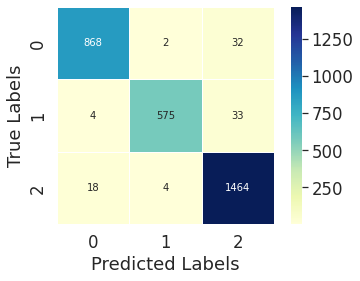

In [43]:
cm = confusion_matrix(y_test, prediction_test)
sns.set(rc={'figure.figsize':(10,10)}, font_scale=1.5)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')

In [44]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks across frames')

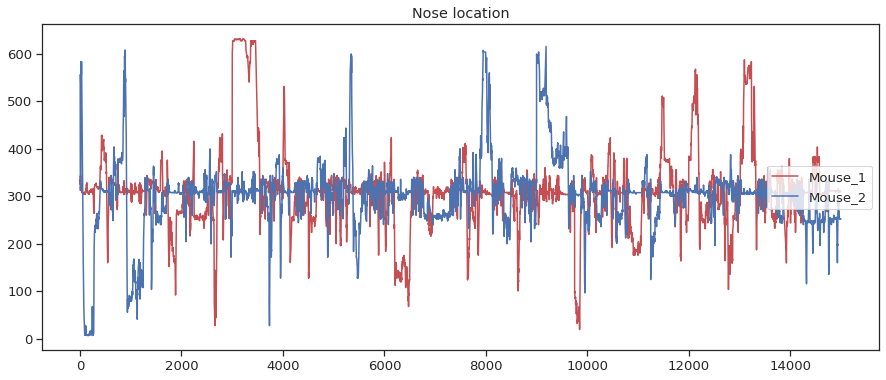

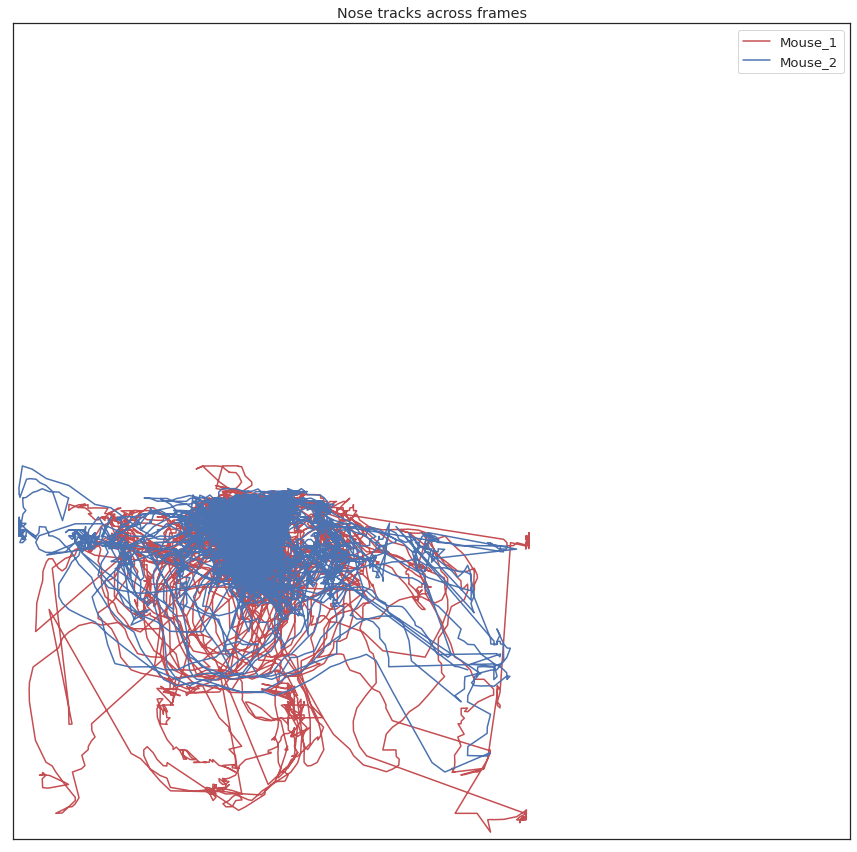

In [45]:
# Figure 1
plt.figure()

plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')
# plt.plot(-1*nose_loc[:,1,0], 'r')
# plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")

plt.title('Nose location')

# Figure 2
plt.figure(figsize=(15,15))

plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks across frames')

## More advanced visualizations (In Progress)

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [46]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [47]:
thx_vel_mouse1 = smooth_diff(nose_loc[:, :, 0].astype('float64'))
thx_vel_mouse2 = smooth_diff(nose_loc[:, :, 1].astype('float64'))

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

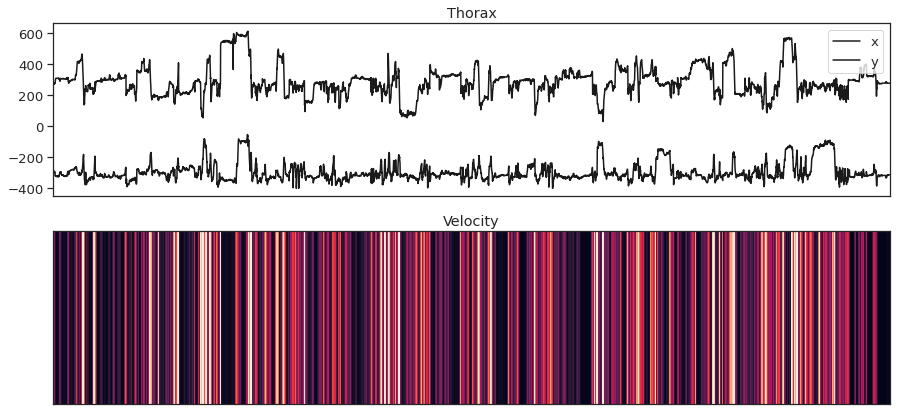

In [48]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
# Using the Transpose of the Matrix
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

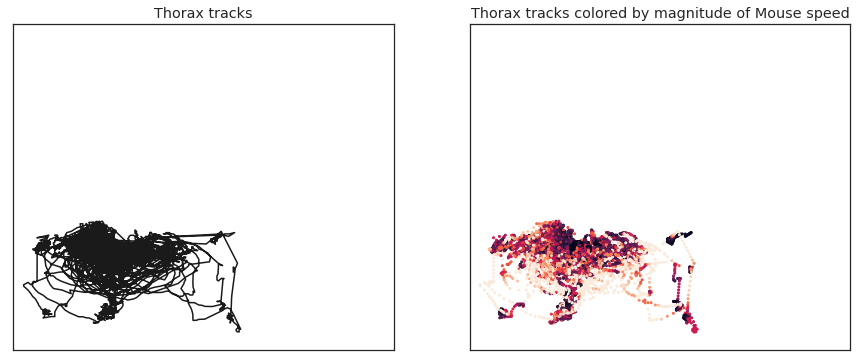

In [49]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [50]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

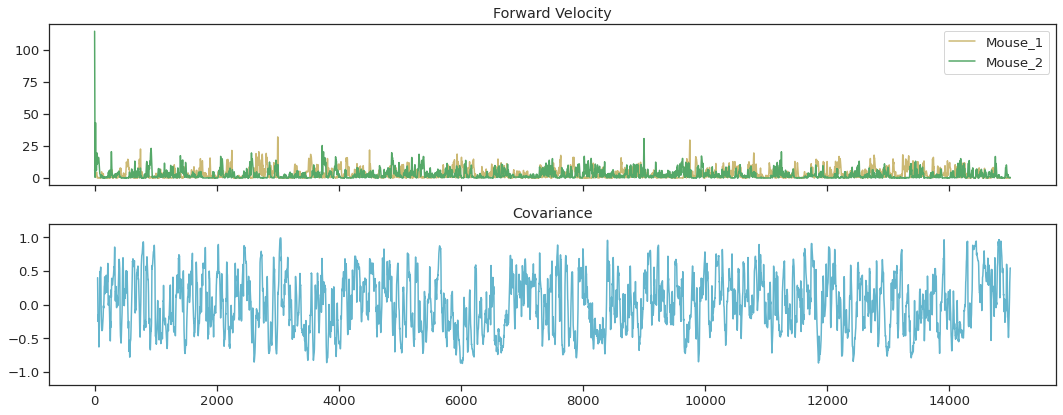

In [51]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

### Todo:
- Use frame rate (30) to correlate have an intuition of which set of frames correspond to which minute/second in the video

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run k-means on the velocities from each frame.


In [52]:
def instance_node_velocities(instance_idx):
    mouse_node_tracks = tracks[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((n_frames, n_bodyparts))

    for n in range(0, n_bodyparts):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_tracks[:, n, :])
    
    return mouse_node_velocities

In [53]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(n_bodyparts), bodyparts, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

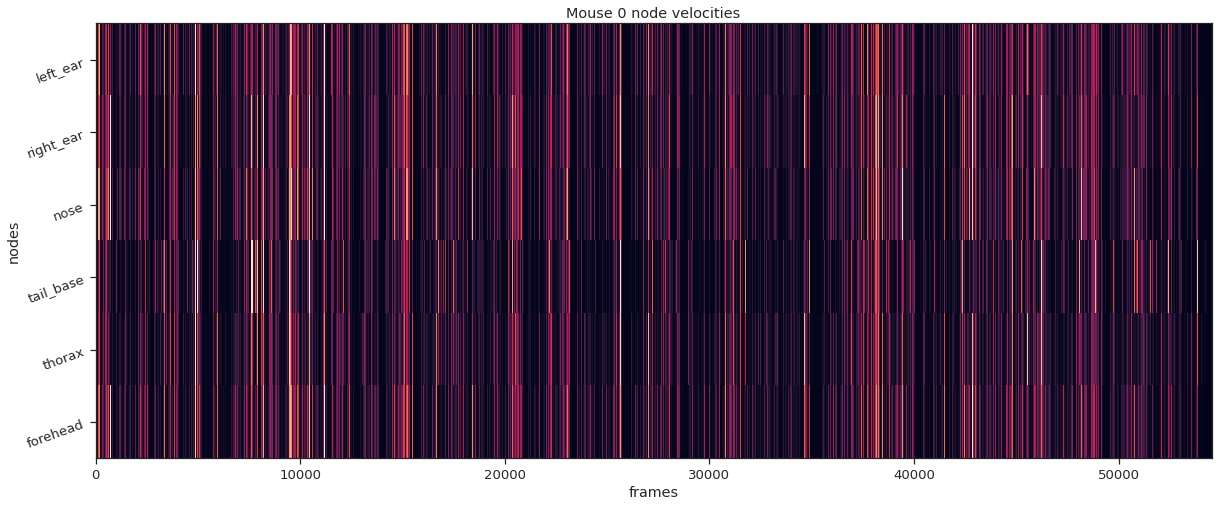

In [54]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

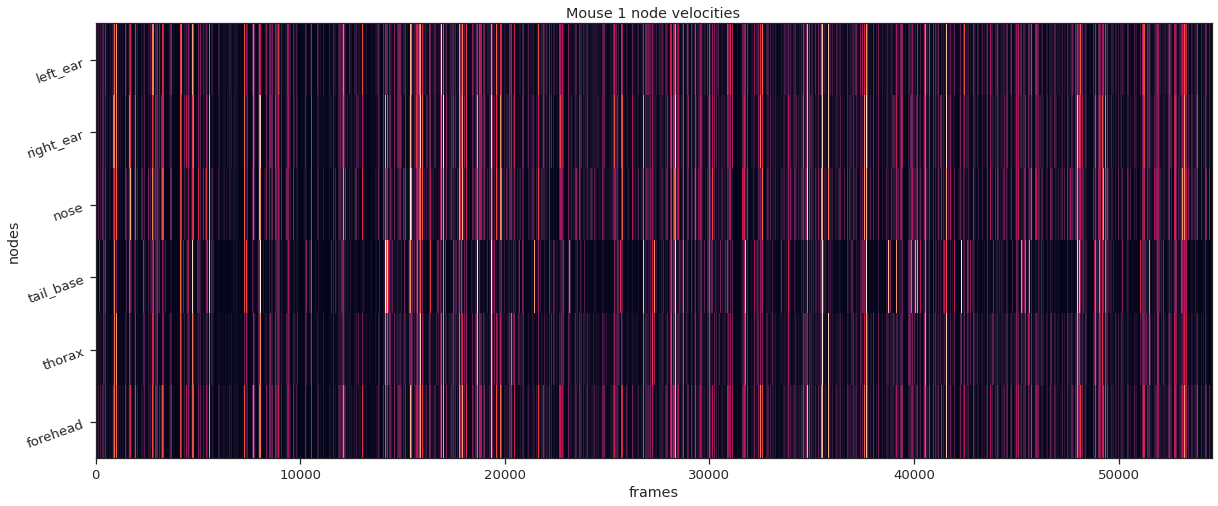

In [55]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [56]:
from sklearn.cluster import KMeans

In [57]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

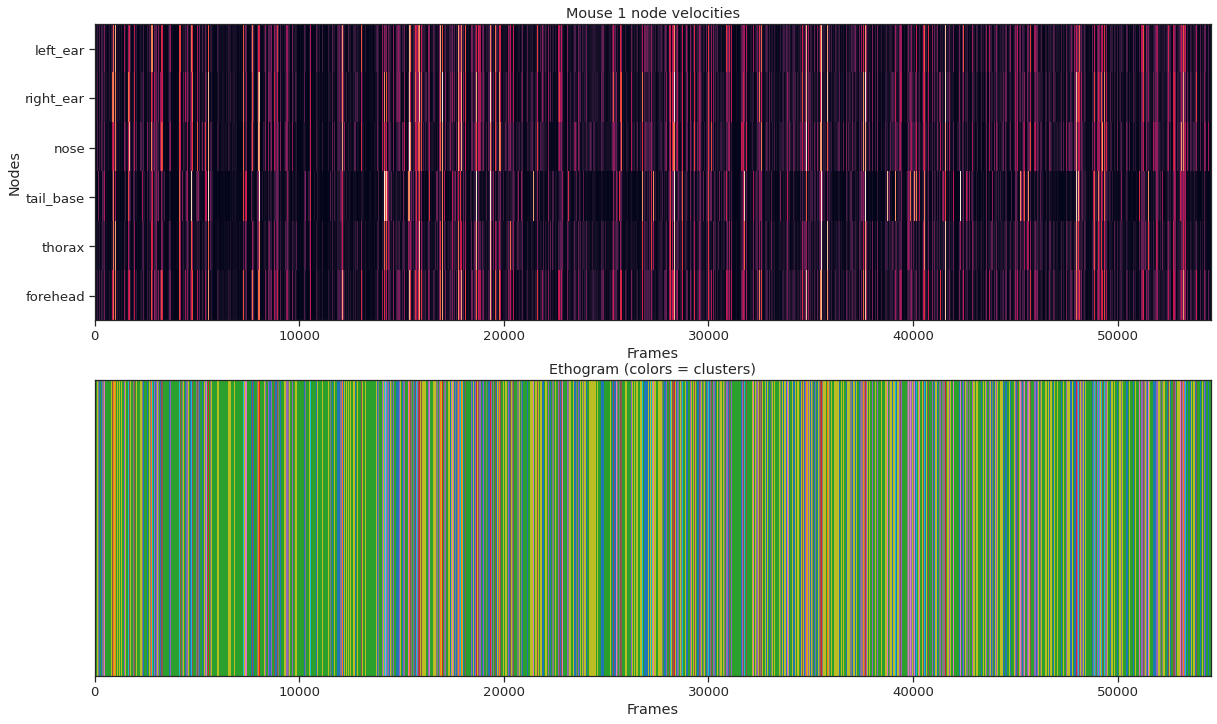

In [58]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(n_bodyparts))
ax1.set_yticklabels(bodyparts);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,n_frames)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");